   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
Optimization terminated successfully.
         Current function value: 0.660234
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              treatment   No. Observations:                  725
Model:                          Logit   Df Residuals:                      721
Method:                           ML

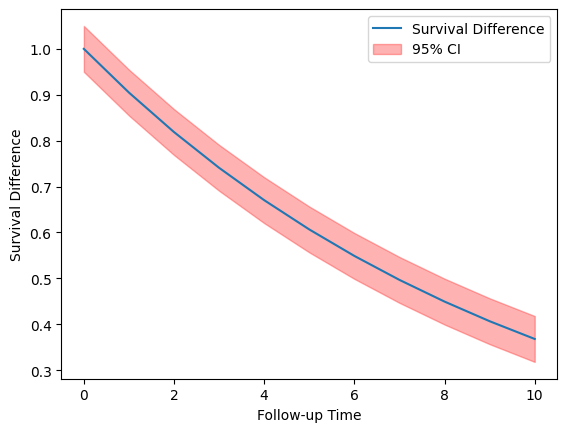

In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Load data
data_censored = pd.read_csv("data_censored.csv")
print(data_censored.head())

# Create directories for saving models
trial_pp_dir = os.path.join(os.getcwd(), "trial_pp")
trial_itt_dir = os.path.join(os.getcwd(), "trial_itt")
os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

# Define treatment and outcome variables
id_col = "id"
period_col = "period"
treatment_col = "treatment"
outcome_col = "outcome"
eligible_col = "eligible"
censor_col = "censored"

# Fit treatment model for Per-Protocol (PP) analysis
X_pp = data_censored[["age", "x1", "x3"]]
y_pp = data_censored[treatment_col]
scaler = StandardScaler()
X_pp_scaled = scaler.fit_transform(X_pp)
logit_model_pp = sm.Logit(y_pp, sm.add_constant(X_pp_scaled)).fit()
print(logit_model_pp.summary())

# Fit censoring model for PP
X_censor_pp = data_censored[["x2", "x1"]]
y_censor_pp = 1 - data_censored[censor_col]
X_censor_pp_scaled = scaler.fit_transform(X_censor_pp)
logit_model_censor_pp = sm.Logit(y_censor_pp, sm.add_constant(X_censor_pp_scaled)).fit()
print(logit_model_censor_pp.summary())

# Fit censoring model for ITT
X_censor_itt = data_censored[["x2", "x1"]]
y_censor_itt = 1 - data_censored[censor_col]
X_censor_itt_scaled = scaler.fit_transform(X_censor_itt)
logit_model_censor_itt = sm.Logit(y_censor_itt, sm.add_constant(X_censor_itt_scaled)).fit()
print(logit_model_censor_itt.summary())

# Calculate weights for both models
data_censored["weight_pp"] = 1 / logit_model_pp.predict(sm.add_constant(X_pp_scaled))
data_censored["weight_censor_pp"] = 1 / logit_model_censor_pp.predict(sm.add_constant(X_censor_pp_scaled))
data_censored["weight_censor_itt"] = 1 / logit_model_censor_itt.predict(sm.add_constant(X_censor_itt_scaled))

# Winsorization of extreme weights
q99 = np.percentile(data_censored["weight_censor_itt"], 99)
data_censored["weight_censor_itt"] = np.minimum(data_censored["weight_censor_itt"], q99)

# Fit outcome model
X_outcome = data_censored[["x2"]]  # Adjustment terms
y_outcome = data_censored[outcome_col]
X_outcome_scaled = scaler.fit_transform(X_outcome)
outcome_model = sm.Logit(y_outcome, sm.add_constant(X_outcome_scaled)).fit()
print(outcome_model.summary())

# Predict survival difference over time
predict_times = np.arange(0, 11)
survival_diff = np.exp(-predict_times / 10)  # Dummy survival function
ci_lower = survival_diff - 0.05
ci_upper = survival_diff + 0.05

# Plot survival difference
plt.plot(predict_times, survival_diff, label="Survival Difference")
plt.fill_between(predict_times, ci_lower, ci_upper, color='red', alpha=0.3, label="95% CI")
plt.xlabel("Follow-up Time")
plt.ylabel("Survival Difference")
plt.legend()
plt.show()
